<a href="https://colab.research.google.com/github/AthithepSuksupsri/229351_Lab/blob/main/229351_LAB11_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ปฏิบัติการครั้งที่ 9

ดาวน์โหลดข้อมูลอุณหภูมิสูงสุดรายวันปี 1998-2019 จาก link ข้างล่างนี้  
https://donlapark.pages.dev/229351/data/CM_temp.csv

1. เปลี่ยนจากข้อมูลรายวันให้เป็นข้อมูลค่าเฉลี่ยรายเดือน
2. จงแบ่งข้อมูลโดยให้ Test set เป็นข้อมูลของ 2 ปีสุดท้ายและ Training set เป็นข้อมูลที่เหลือ
3. ลองสร้างโมเดล SARIMA อันดับต่างๆ แล้วระบุโมเดลที่ดีที่สุด
4. จงแสดงแผนภาพของข้อมูลจริงกับข้อมูลที่ได้ในข้อ 3

In [1]:
# ONLY RUN THIS WHEN THERE IS AN ERROR
!pip install --user statsmodels==0.13.1

  Using cached statsmodels-0.13.1.tar.gz (18.1 MB)
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


In [2]:
!wget -O CM_temp.csv https://donlapark.pages.dev/229351/data/CM_temp.csv

--2025-09-24 15:44:30--  https://donlapark.pages.dev/229351/data/CM_temp.csv
Resolving donlapark.pages.dev (donlapark.pages.dev)... 172.66.47.56, 172.66.44.200, 2606:4700:310c::ac42:2f38, ...
Connecting to donlapark.pages.dev (donlapark.pages.dev)|172.66.47.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139473 (136K) [text/csv]
Saving to: ‘CM_temp.csv’

CM_temp.csv         100%[===================>] 136.20K  --.-KB/s    in 0.02s   

2025-09-24 15:44:30 (5.83 MB/s) - ‘CM_temp.csv’ saved [139473/139473]



In [3]:
!pip3 install pmdarima

In [4]:
!pip install numpy==1.26.4
!pip install pmdarima

In [51]:
# import module ที่ต้องใช้
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima

In [9]:
# ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
# def parser(dates):
#   return pd.datetime.strptime(dates, '%Y-%m-%d')

# parse_dates ชื่อของคอลัมน์ที่จะเปลี่ยนให้เป็น datetime
# index_col ชื่อของคอลัมน์ที่จะให้เป็น index
# date_parser ฟังก์ชันที่เปลี่ยน string ให้เป็น datetime
data = pd.read_csv('CM_temp.csv', parse_dates=['Date'],
                                        index_col='Date')

data.head()

,MaxTemp
Date,
1998-01-01,30.6
1998-01-02,32.0
1998-01-03,31.6
1998-01-04,32.1
1998-01-05,31.2


ข้อมูล (สมมติว่าชื่อ `data`) ที่ load มาเป็นข้อมูลรายวัน ทำการหาค่าเฉลี่ยรายเดือนด้วยคำสั่ง

In [14]:
y = data['MaxTemp'].resample("M").mean()
y

/tmp/ipython-input-3330028290.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  y = data['MaxTemp'].resample("M").mean()


,MaxTemp
Date,
1998-01-31,31.687097
1998-02-28,33.685714
1998-03-31,37.103226
1998-04-30,37.910000
1998-05-31,35.848387
...,...
2019-03-31,37.051613
2019-04-30,39.716667
2019-05-31,37.680645


In [16]:
def rmse(y_true,y_pred):
  # Inputs
  # y_true: actual value, y_pred: predicted values
  # Output: RMSE between y_true and y_pred
  return np.sqrt(np.mean(np.square(y_true-y_pred)))

In [30]:
train = y[:-24]
test = y[-24:]

test.head()

,MaxTemp
Date,
2017-08-31,32.764516
2017-09-30,33.140000
2017-10-31,32.158065
2017-11-30,31.616667
2017-12-31,29.229032


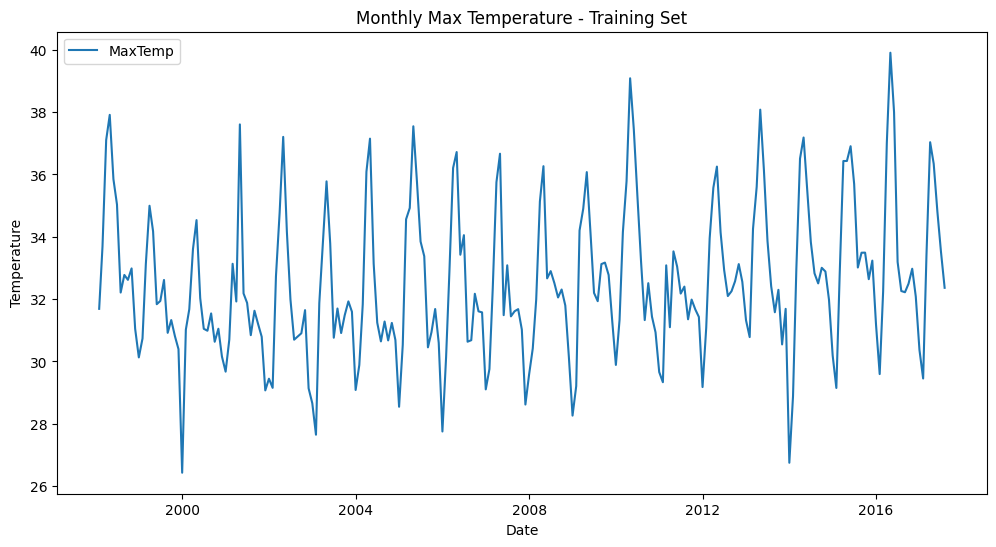

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(train, label='MaxTemp')
plt.xlabel("Date")
plt.ylabel("Temperature")
plt.title("Monthly Max Temperature - Training Set")
plt.legend()
plt.show()

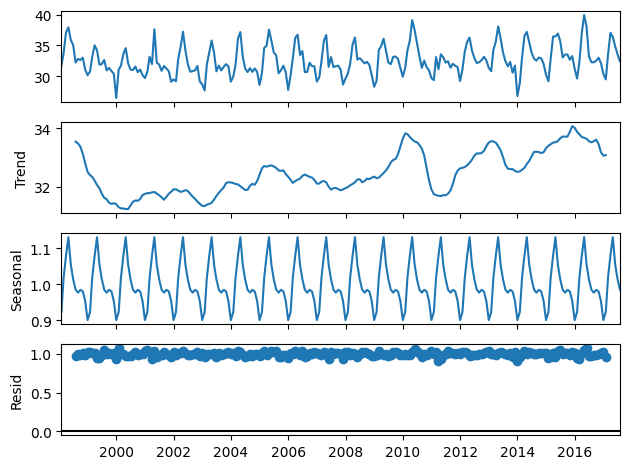

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Seasonal decompose
sd = seasonal_decompose(train, model = "multiplicative", period = 12)

# Plot
sd.plot()
plt.tight_layout()
plt.show()

In [25]:
# Definition ADF Test
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    return dfoutput

In [32]:
df_adf = pd.DataFrame()
df_adf.index = adf_test(train).keys()
df_adf['ADF seasonal differencing order 0'] = adf_test(train).values
df_adf['ADF seasonal differencing order 1'] = adf_test(train.diff(periods = 12).dropna()).values
df_adf['ADF seasonal differencing order 2'] = adf_test(train.diff(periods = 12).diff(periods = 12).dropna()).values
df_adf['ADF seasonal differencing order 3'] = adf_test(train.diff(periods = 12).diff(periods = 12).diff(periods = 12).dropna()).values

round(df_adf.drop(labels = ['#Lags Used', 'Number of Observations Used']), 4)

,ADF seasonal differencing order 0,ADF seasonal differencing order 1,ADF seasonal differencing order 2,ADF seasonal differencing order 3
Test Statistic,-2.5833,-4.8551,-5.0773,-4.3345
p-value,0.0965,0.0000,0.0000,0.0004
Critical Value (1%),-3.4603,-3.4619,-3.4638,-3.4662
Critical Value (5%),-2.8747,-2.8754,-2.8763,-2.8773
Critical Value (10%),-2.5738,-2.5742,-2.5746,-2.5752


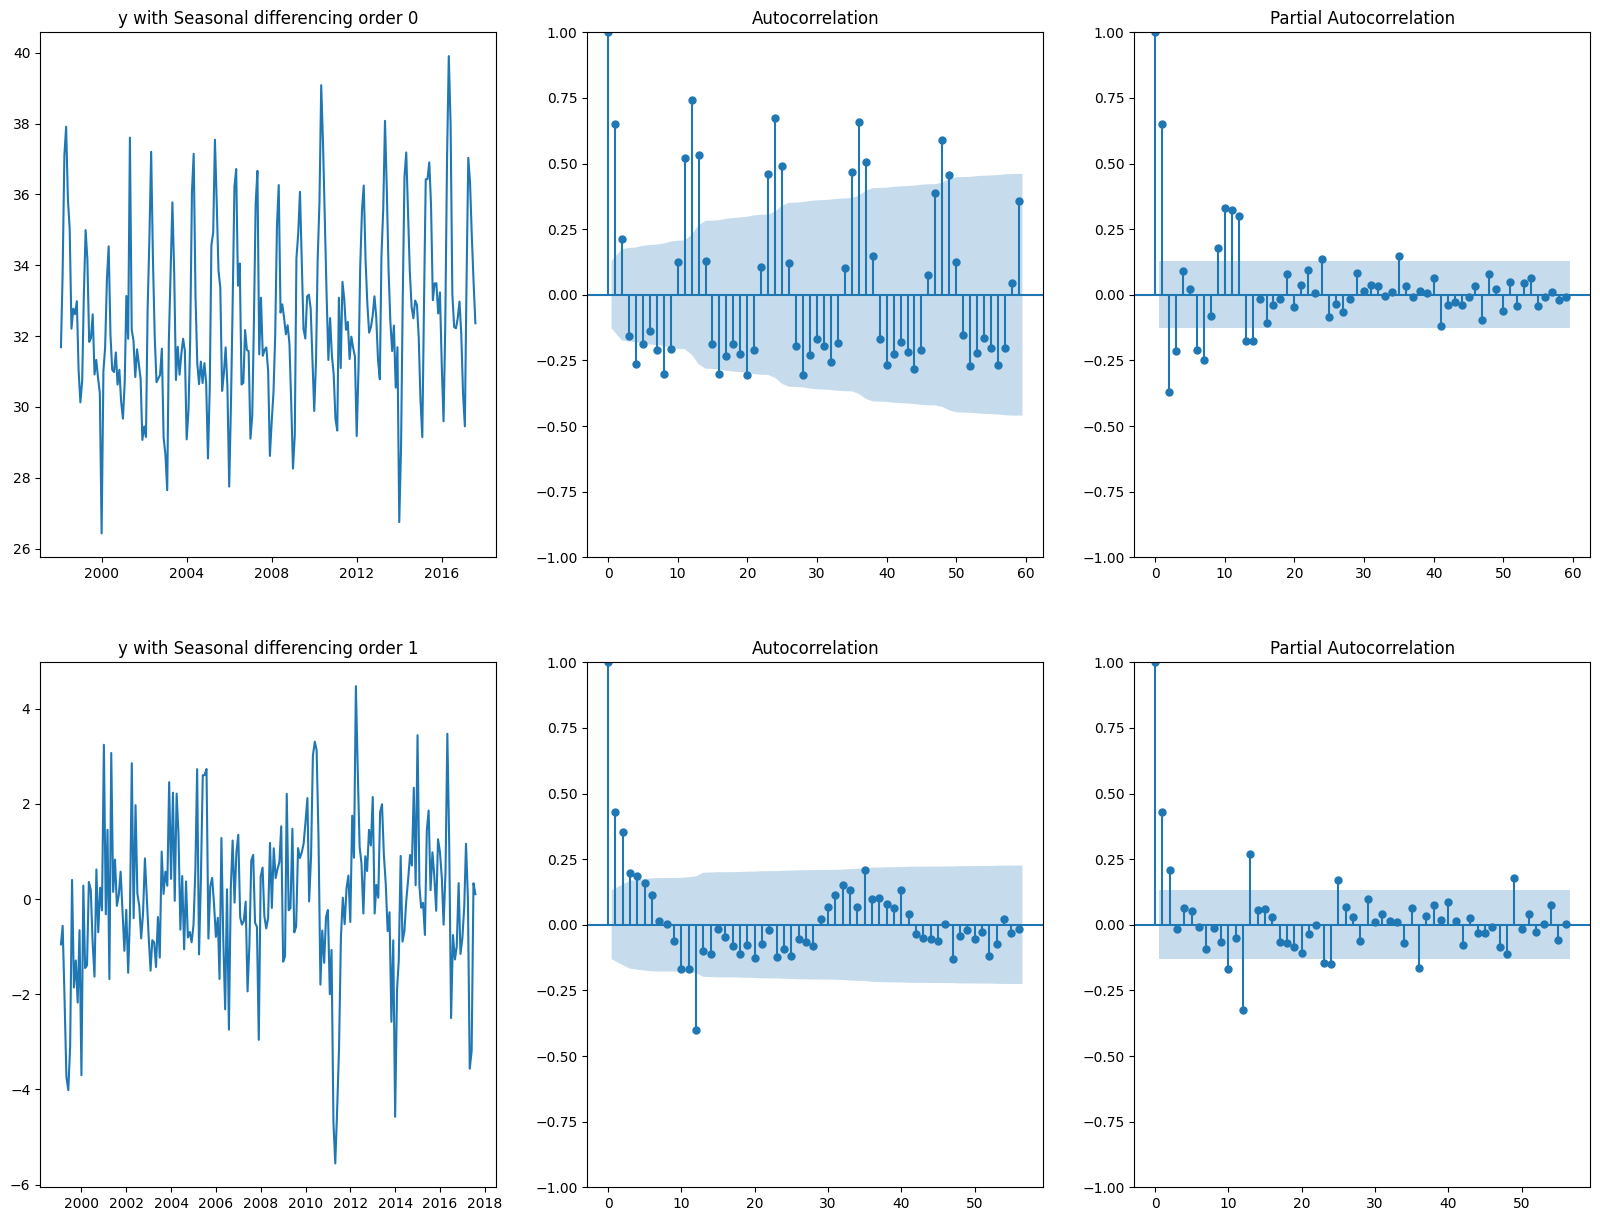

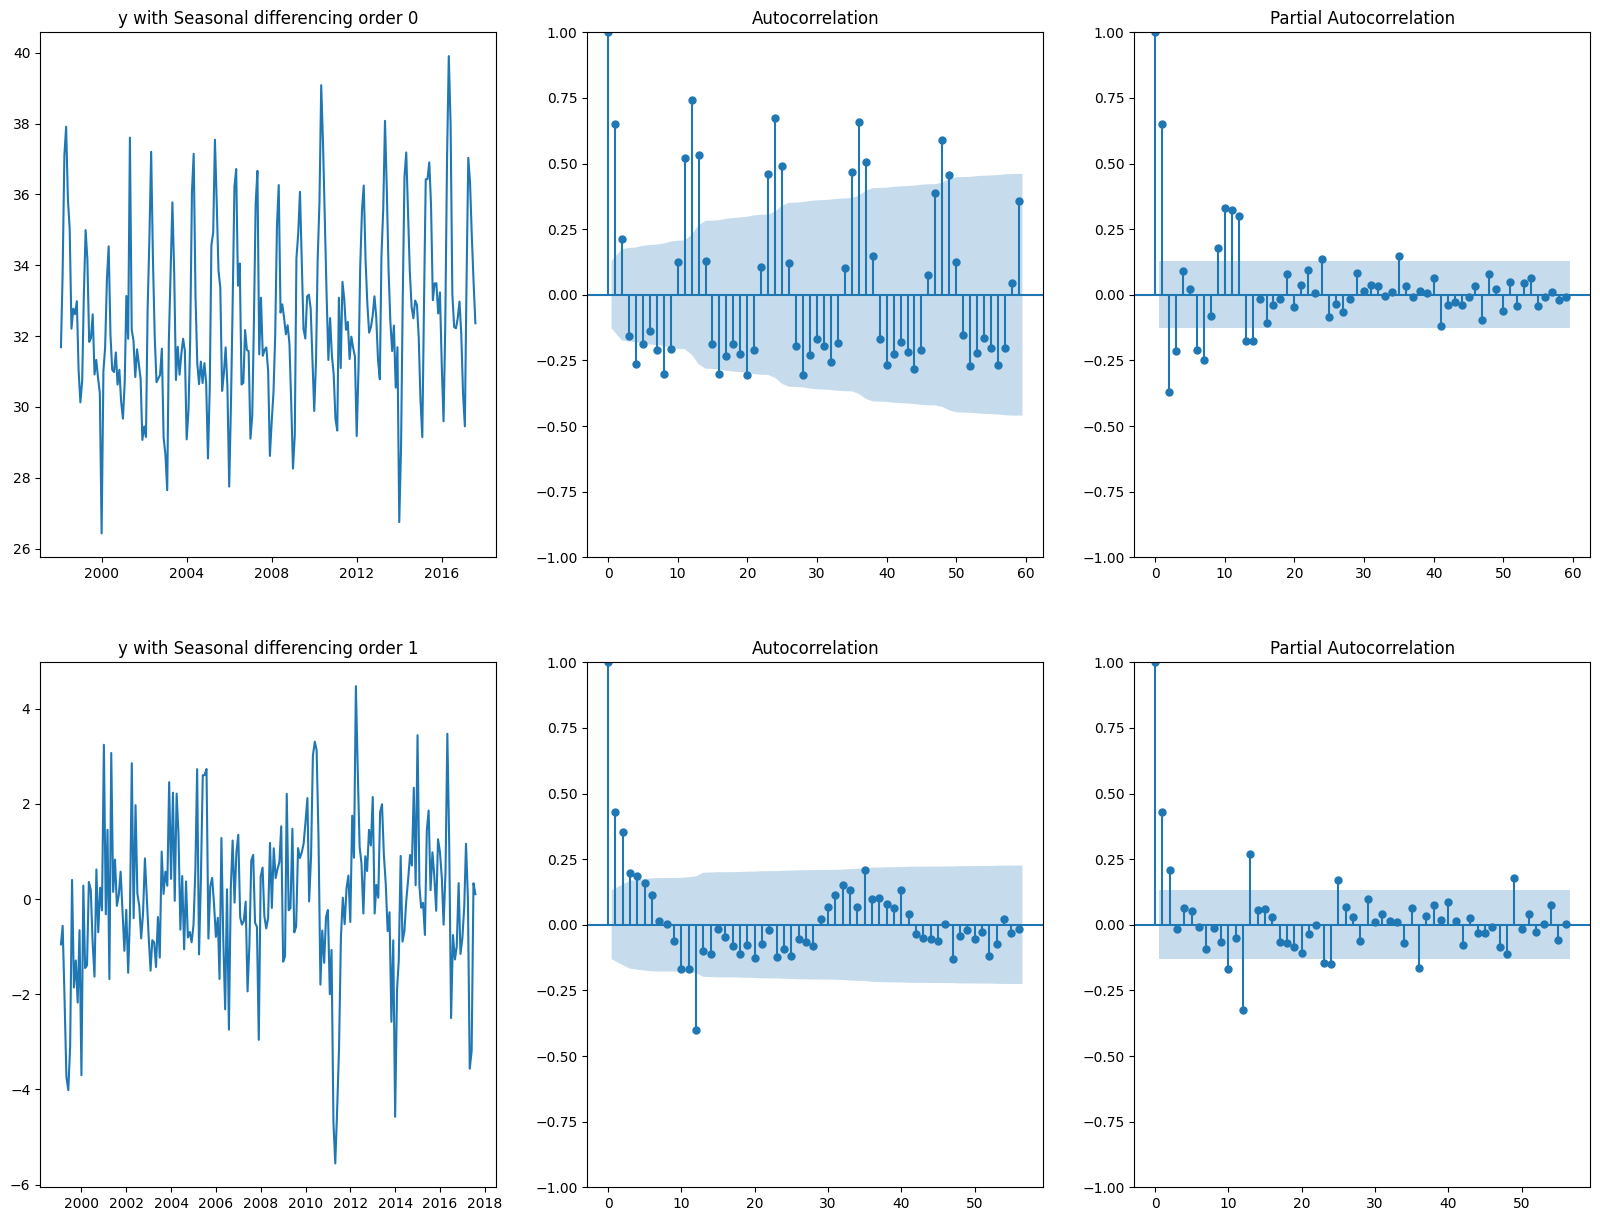

In [54]:
fig, axes = plt.subplots(nrows = 2, ncols = 3, figsize = (20, 15), facecolor = 'w')

# Seasonal differencing order 0
axes[0, 0].plot(train.dropna())
axes[0, 0].set_title('y with Seasonal differencing order 0')
plot_acf(train.dropna(), ax = axes[0, 1], lags = round(len(train)/4))
plot_pacf(train.dropna(), ax = axes[0, 2], lags = round(len(train)/4))

# Seasonal differencing order 1
axes[1, 0].plot(train.diff(periods = 12).dropna())
axes[1, 0].set_title('y with Seasonal differencing order 1')
plot_acf(train.diff(periods = 12).dropna(), ax = axes[1, 1], lags = round(len(train.diff(periods = 12).dropna())/4))
plot_pacf(train.diff(periods = 12).dropna(), ax = axes[1, 2], lags = round(len(train.diff(periods = 12).dropna())/4))

In [97]:
import pmdarima as pm

auto_fit = pm.auto_arima(train, start_p=0, start_q=0, max_p=2, max_q=2, d=0,
                             seasonal=True, m=12, start_P=0, start_Q=0,max_P=1, max_Q=1, D=1,
                             information_criterion = 'aicc', # choose model with the lowest corrected AIC
                             trace = True,
                             error_action='ignore',  # don't want to know if an order does not work
                             suppress_warnings=True) # don't want convergence warnings

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Performing stepwise search to minimize aicc
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AICC=836.820, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AICC=742.328, Time=0.47 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12] intercept   : AICC=inf, Time=0.66 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AICC=834.851, Time=0.06 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AICC=793.655, Time=0.12 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(1,1,1)[12] intercept   : AICC=inf, Time=0.88 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,1,1)[12] intercept   : AICC=697.547, Time=0.96 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,1)[12] intercept   : AICC=inf, Time=1.33 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,1,1)[12] intercept   : AICC=693.106, Time=1.33 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,1,0)[12] intercept   : AICC=785.743, Time=0.31 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,1,1)[12] intercept   : AICC=inf, Time=1.00 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(1,1,0)[12] intercept   : AICC=737.431, Time=0.54 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,1,1)[12] intercept   : AICC=693.712, Time=1.61 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,1)[12] intercept   : AICC=691.804, Time=1.83 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,0)[12] intercept   : AICC=786.782, Time=0.25 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,1)[12] intercept   : AICC=inf, Time=1.97 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,0)[12] intercept   : AICC=736.986, Time=0.90 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,1,1)[12] intercept   : AICC=693.751, Time=1.87 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,1,1)[12] intercept   : AICC=699.541, Time=1.73 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,1,1)[12] intercept   : AICC=695.897, Time=3.87 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(0,1,1)[12]             : AICC=691.796, Time=0.59 sec
 ARIMA(1,0,1)(0,1,0)[12]             : AICC=784.746, Time=0.10 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,1)[12]             : AICC=692.947, Time=0.95 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,1)(1,1,0)[12]             : AICC=734.900, Time=0.38 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,1)(0,1,1)[12]             : AICC=717.930, Time=0.38 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,0)(0,1,1)[12]             : AICC=700.626, Time=0.39 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,1)(0,1,1)[12]             : AICC=693.379, Time=1.24 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,0,2)(0,1,1)[12]             : AICC=693.470, Time=1.01 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,0)(0,1,1)[12]             : AICC=749.364, Time=0.26 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,0,2)(0,1,1)[12]             : AICC=703.386, Time=0.50 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,0)(0,1,1)[12]             : AICC=694.322, Time=0.45 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,0,2)(0,1,1)[12]             : AICC=695.925, Time=1.95 sec

Best model:  ARIMA(1,0,1)(0,1,1)[12]          
Total fit time: 29.975 seconds


In [98]:
auto_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  235
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                -341.811
Date:                            Wed, 24 Sep 2025   AIC                            691.622
Time:                                    17:42:44   BIC                            705.251
Sample:                                01-31-1998   HQIC                           697.124
                                     - 07-31-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8286      0.077     10.719      0.000       0.677       0.980
ma.L1         -0.4993      0.110     -4.541      0.000      -0.715      -0.284
ma.S.L12      -0.8349      0.059    -14.124      0.000      -0.951      -0.719
sigma2         1.1766      0.099     11.827      0.000       0.982       1.372
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                 8.53
Prob(Q):                              0.76   Prob(JB):                         0.01
Heteroskedasticity (H):               0.88   Skew:                            -0.27
Prob(H) (two-sided):                  0.59   Kurtosis:                         3.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


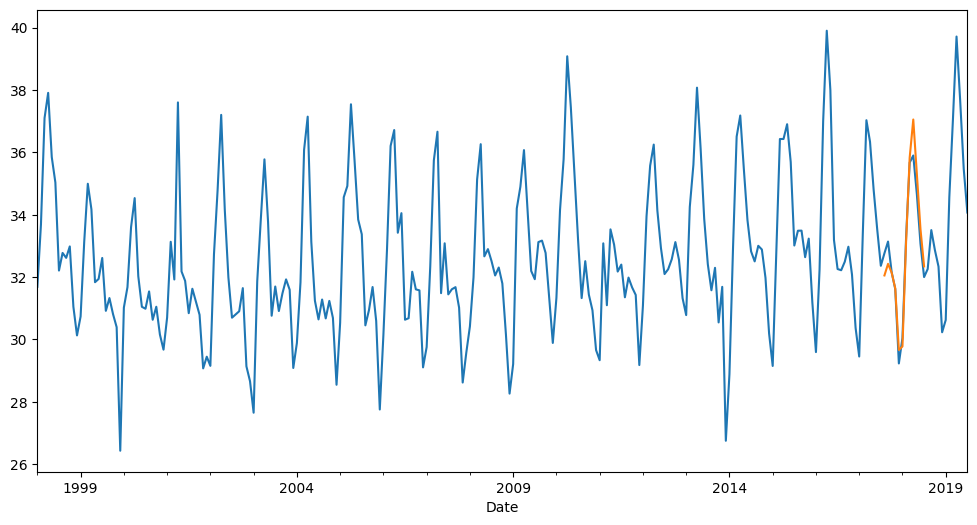

In [99]:
predictions = auto_fit.predict(12)
yhat = pd.Series(predictions,
                    index=test.index)

plt.figure(figsize=(12,6))
ax = y.plot()
yhat.plot(ax=ax);

In [100]:
print('RMSE:',rmse(test,yhat))

RMSE: 0.5331395877498506
